## Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time
from datetime import date, timedelta, datetime
import pandas_gbq
from google.cloud import bigquery
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import math

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import gc
warnings.filterwarnings('ignore')
collected_objects = gc.collect()

/opt/conda/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [2]:
os.environ["http_proxy"] = "http://geoproxy.kohls.com:3128"
os.environ["HTTP_PROXY"] = "http://geoproxy.kohls.com:3128"
os.environ["https_proxy"] = "http://geoproxy.kohls.com:3128"
os.environ["HTTPS_PROXY"] = "http://geoproxy.kohls.com:3128"

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

del os.environ['http_proxy']
del os.environ['HTTP_PROXY']
del os.environ['https_proxy']
del os.environ['HTTPS_PROXY']

os.chdir('/home/jupyter/SalesForecasting/GmWorkingData/Unsubscribe_email')

Client creating using default project: kohls-bda-mkt-lle


# Monthly Training

## Data Ingestion

In [3]:
t1 = time.time()
## qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_for_email_unsubsribe_data1'''
# qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_v3_OOS'''
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_v3_train_OOS_2'''
training_data_m= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")
# final_data = final_data.drop_duplicates()

Downloading: 100%|██████████|
Total time taken to read the data : 3.860307041803996 mins


In [4]:
t1 = time.time()
## qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_for_email_unsubsribe_data1'''
# qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_v3_OOS'''
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_v3_test_OOS_2'''
testing_data_m= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")
# final_data = final_data.drop_duplicates()

Downloading: 100%|██████████|
Total time taken to read the data : 1.5511707067489624 mins


## Data Preparation

In [5]:
training_data_m.shape

(19173594, 76)

In [6]:
pd.set_option('display.max_columns', None)
training_data_m.head(2)

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,S9B7CUzp6t-5@iUVa4qA.T9T,2023-01-01,1,0,0,5,0,0,13,1006725484,<NA>,<NA>,<NA>,4,2,52,87500,0,None,25,32,777.610000000,16,269.010000000,0,0E-9,0E-9,30.000000000,0E-9,63.740000000,0E-9,133.110000000,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0
1,zo65FoPoE@PsL82Ob.pWh,2023-01-01,1,0,73,43,0,315,176,131187295,<NA>,990,5,25,2,53,<NA>,1,6.384329539,48,88,734.440000000,76,615.320000000,88,734.440000000,0E-9,0E-9,0E-9,390.760000000,0E-9,0E-9,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0


In [7]:
training_data_m.columns

Index(['email_addr', 'vantage_date', 'month_num', 'ttl_num_of_cls_in_cur_mth',
       'ttl_num_of_opens_in_cur_mth', 'ttl_num_of_mails_sent_in_cur_mth',
       'ttl_num_of_cls_in_lst_3_mth', 'ttl_num_of_op_in_lst_3_mth',
       'ttl_num_of_mails_snt_in_lst_3_mth', 'cust_id', 'ttl_opt_out_num',
       'rec_opt_in_days', 'mail_cnt_asn_pr_cust', 'total_trip_cnt',
       'months_to_last_trans', 'cust_age', 'med_incm', 'kc_holder',
       'dist_to_store', 'lst_qrt_trp_cnt', 'lst_qrt_pur_qnts',
       'lst_qrt_spt_amt', 'lst_qrt_dis_qnt', 'lst_qrt_dis_spt_amt',
       'lst_qrt_pur_qnts_wt_kc_card', 'lst_qrt_spt_amt_wt_kc_card',
       'ACTIVE_trans_pur_amt_for_lst_qrt', 'BEAUTY_trans_pur_amt_for_lst_qrt',
       'CHILDRENS_trans_pur_amt_for_lst_qrt', 'HOME_trans_pur_amt_for_lst_qrt',
       'MENS_trans_pur_amt_for_lst_qrt', 'WOMENS_trans_pur_amt_for_lst_qrt',
       'YOUNG_WOMENS_trans_pur_amt_for_lst_qrt', 'sec_lst_qrt_trp_cnt',
       'sec_lst_qrt_pur_qnts', 'sec_lst_qrt_spt_amt', 'sec_lst

In [8]:
col_to_convert_float_ls = ['dist_to_store',
'lst_qrt_spt_amt',
'lst_qrt_dis_spt_amt',
'lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_lst_qrt',
'BEAUTY_trans_pur_amt_for_lst_qrt',
'CHILDRENS_trans_pur_amt_for_lst_qrt',
'HOME_trans_pur_amt_for_lst_qrt',
'MENS_trans_pur_amt_for_lst_qrt',
'WOMENS_trans_pur_amt_for_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_lst_qrt',
'sec_lst_qrt_spt_amt',
'sec_lst_qrt_dis_spt_amt',
'sec_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_sec_lst_qrt',
'BEAUTY_trans_pur_amt_for_sec_lst_qrt',
'CHILDRENS_trans_pur_amt_for_sec_lst_qrt',
'HOME_trans_pur_amt_for_sec_lst_qrt',
'MENS_trans_pur_amt_for_sec_lst_qrt',
'WOMENS_trans_pur_amt_for_sec_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt',
'trd_lst_qrt_spt_amt',
'trd_lst_qrt_dis_spt_amt',
'trd_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_trd_lst_qrt',
'BEAUTY_trans_pur_amt_for_trd_lst_qrt',
'CHILDRENS_trans_pur_amt_for_trd_lst_qrt',
'HOME_trans_pur_amt_for_trd_lst_qrt',
'MENS_trans_pur_amt_for_trd_lst_qrt',
'WOMENS_trans_pur_amt_for_trd_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt',
'frt_lst_qrt_spt_amt',
'frt_lst_qrt_dis_spt_amt',
'frt_lst_qrt_spt_amt_wt_kc_card',
'ACTIVE_trans_pur_amt_for_frt_lst_qrt',
'BEAUTY_trans_pur_amt_for_frt_lst_qrt',
'CHILDRENS_trans_pur_amt_for_frt_lst_qrt',
'HOME_trans_pur_amt_for_frt_lst_qrt',
'MENS_trans_pur_amt_for_frt_lst_qrt',
'WOMENS_trans_pur_amt_for_frt_lst_qrt',
'YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt']

In [9]:
for col in col_to_convert_float_ls:
    training_data_m[col] = training_data_m[col].astype(float)

In [9]:
# # PLOT FOR UNSUBSCRIPTION RATIO

# unsubscription_status = round(training_data_m['unsubscribe_or_not'].value_counts()/training_data_m.shape[0]*100)
# print("Number of customers unsubscribe:")
# print(training_data_m['unsubscribe_or_not'].value_counts())
# print("Number of customers unsubscribe in %:")
# print(unsubscription_status)
# # print(unsubscription_status.index)

# sns.countplot(x=training_data_m["unsubscribe_or_not"],data=training_data_m)
# plt.show()

In [10]:
testing_data_m.shape

(6391197, 76)

In [11]:
pd.set_option('display.max_columns', None)
testing_data_m.head(2)

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,9y3r8uDXv@Z0ND3.u0J,2023-01-01,1,0,0,39,2,8,172,40252187,2,1538,3,82,3,33,47500,1,19.512283030,26,26,624.480000000,12,370.760000000,26,624.480000000,89.980000000,0E-9,0E-9,87.940000000,0E-9,161.980000000,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0
1,Yv30Qbwqoj@rcnWR.dv6,2023-01-01,1,0,53,40,0,205,174,9926866,2,1538,1,38,2,29,62500,0,3.688784496,15,17,255.070000000,16,239.670000000,0,0E-9,0E-9,0E-9,0E-9,34.930000000,0E-9,16.000000000,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0,0,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,1,1,0E-9,0,0E-9,0,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,0


In [12]:
for col in col_to_convert_float_ls:
    testing_data_m[col] = testing_data_m[col].astype(float)

In [14]:
X_train = training_data_m.drop(columns = ["email_addr","cust_id", "vantage_date","unsubscribe_or_not"], axis = 1)
y_train = training_data_m['unsubscribe_or_not'].astype(int)
del training_data_m
X_test = testing_data_m.drop(columns = ["email_addr","cust_id", "vantage_date","unsubscribe_or_not"], axis = 1)
y_test = testing_data_m['unsubscribe_or_not'].astype(int)
del testing_data_m

In [15]:
collected_objects = gc.collect()

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19173594, 72), (19173594,), (6391197, 72), (6391197,))

## Model Training

### XGBC

In [17]:
# TRAINING
t1 = time.time()
xgbc  =XGBClassifier()
xgbc.fit(X_train,y_train)
print(f"Total time taken to train the model : {(time.time()-t1)/60} mins")

# TESTING ON OOS
y_pred_xgbc = xgbc.predict(X_test)

Total time taken to train the model : 6.731160243352254 mins


In [18]:
print(accuracy_score(y_test,y_pred_xgbc),
precision_score(y_test,y_pred_xgbc),
recall_score(y_test,y_pred_xgbc),
f1_score(y_test,y_pred_xgbc))

0.995744459136528 0.8374827563555147 0.6591696396256657 0.7377039694479807


In [19]:
confusion_matrix(y_test,y_pred_xgbc)

array([[6325752,    7422],
       [  19776,   38247]])

### XGBC with scale_pos_ratio

In [20]:
round(len(y_train[y_train==0])/len(y_train[y_train==1]))

109

In [24]:
# TRAINING
xgbc1  =XGBClassifier(scale_pos_weight=109)
xgbc1.fit(X_train,y_train)

# TESTING ON OOS
y_pred_xgbc1 = xgbc1.predict(X_test)

In [25]:
print(accuracy_score(y_test,y_pred_xgbc1),
precision_score(y_test,y_pred_xgbc1),
recall_score(y_test,y_pred_xgbc1),
f1_score(y_test,y_pred_xgbc1))

0.9614674684570043 0.18167060112690156 0.9257708150216294 0.3037367720193045


In [26]:
confusion_matrix(y_test,y_pred_xgbc1)

array([[6091212,  241962],
       [   4307,   53716]])

### HGBC

In [21]:
# TRAINING
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train,y_train)

# TESTING ON OOS
y_pred_hgbc = hgbc.predict(X_test)

In [22]:
print(accuracy_score(y_test,y_pred_hgbc),
precision_score(y_test,y_pred_hgbc),
recall_score(y_test,y_pred_hgbc),
f1_score(y_test,y_pred_hgbc))

0.9952398588245676 0.7928319823452022 0.643934301914758 0.7106677191414088


In [23]:
confusion_matrix(y_test,y_pred_hgbc)

array([[6323411,    9763],
       [  20660,   37363]])

## For testing on Feb data

In [53]:
del X_train
del y_train
del X_test
collected_objects = gc.collect()

In [37]:
t1 = time.time()
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.KA1JB1_email_unsubscribe_feb_v1_OOT_1'''
data_OOT= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 1.189949882030487 mins


In [38]:
for col in col_to_convert_float_ls:
    data_OOT[col] = data_OOT[col].astype(float)

In [39]:
X_test_data_OOT = data_OOT.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_test_data_OOT = data_OOT['unsubscribe_or_not'].astype(int)
#del data_OOT

In [40]:
X_test_data_OOT.shape, y_test_data_OOT.shape

((5835189, 72), (5835189,))

### XGBC

In [41]:
# TESTING ON OOT
y_pred_xgbc_oot = xgbc.predict(X_test_data_OOT)

In [42]:
print(accuracy_score(y_test_data_OOT,y_pred_xgbc_oot),
precision_score(y_test_data_OOT,y_pred_xgbc_oot),
recall_score(y_test_data_OOT,y_pred_xgbc_oot),
f1_score(y_test_data_OOT,y_pred_xgbc_oot))

0.9937859767695614 0.6718454050684505 0.5538491945844451 0.6071676200381348


In [43]:
confusion_matrix(y_test_data_OOT,y_pred_xgbc_oot)

array([[5770907,   13687],
       [  22573,   28022]])

### HGBC

In [42]:
# TESTING ON OOT
y_pred_hgbc_oot = hgbc.predict(X_test_data_OOT)

In [43]:
print(accuracy_score(y_test_data_OOT,y_pred_hgbc_oot),
precision_score(y_test_data_OOT,y_pred_hgbc_oot),
recall_score(y_test_data_OOT,y_pred_hgbc_oot),
f1_score(y_test_data_OOT,y_pred_hgbc_oot))

0.9919793504407148 0.5360351485538656 0.5394040325938262 0.5377143139483176


In [44]:
confusion_matrix(y_test_data_OOT,y_pred_hgbc_oot)

array([[5758582,   23549],
       [  23232,   27207]])

### XGBC with scale_pos_weight

In [44]:
# TESTING ON OOT
y_pred_xgbc1_oot = xgbc1.predict(X_test_data_OOT)

In [45]:
print(accuracy_score(y_test_data_OOT,y_pred_xgbc1_oot),
precision_score(y_test_data_OOT,y_pred_xgbc1_oot),
recall_score(y_test_data_OOT,y_pred_xgbc1_oot),
f1_score(y_test_data_OOT,y_pred_xgbc1_oot))

0.8753536517840296 0.06046368437871021 0.9199920940804427 0.11346990415989684


In [46]:
confusion_matrix(y_test_data_OOT,y_pred_xgbc1_oot)

array([[5061307,  723287],
       [   4048,   46547]])

## Result Analysis

### Features importance

In [18]:
xgbc.feature_importances_

array([0.24608663, 0.1367182 , 0.10247909, 0.02724357, 0.04130836,
       0.01991544, 0.03494381, 0.02212008, 0.10881857, 0.02879862,
       0.01220984, 0.00614881, 0.0037225 , 0.01820694, 0.00345367,
       0.00361003, 0.01823917, 0.0052421 , 0.00535067, 0.00237155,
       0.02310644, 0.02277529, 0.00141279, 0.00242787, 0.00236843,
       0.00182937, 0.00372294, 0.00176953, 0.00205484, 0.01453359,
       0.00263176, 0.00266728, 0.00132697, 0.00151693, 0.00266461,
       0.00275179, 0.00126681, 0.00200578, 0.00163278, 0.00175602,
       0.00130024, 0.00156937, 0.00146896, 0.00233025, 0.00746186,
       0.00249933, 0.00150997, 0.00161267, 0.00147725, 0.00246441,
       0.00141416, 0.00173747, 0.0016785 , 0.00153453, 0.00170933,
       0.0013228 , 0.00124714, 0.00235393, 0.00119488, 0.00227127,
       0.00121969, 0.00170331, 0.00155842, 0.00176461, 0.0013014 ,
       0.0012352 , 0.00138475, 0.00162684, 0.00205989, 0.00145201,
       0.00132615], dtype=float32)

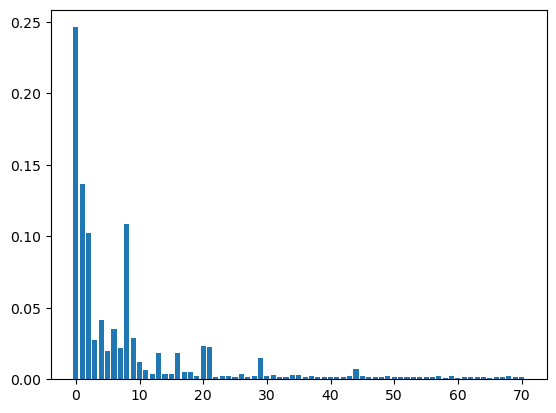

In [19]:
# plot
plt.bar(range(len(xgbc.feature_importances_)), xgbc.feature_importances_)
plt.show()

In [20]:
feature_df = pd.DataFrame(index = [X_train.columns], data = xgbc.feature_importances_)
#feature_df.to_csv("features.csv")

In [21]:
feature_df.head(10)

,0
ttl_num_of_cls_in_cur_mth,0.246087
ttl_num_of_opens_in_cur_mth,0.136718
ttl_num_of_mails_sent_in_cur_mth,0.102479
ttl_opt_out_num,0.027244
rec_opt_in_days,0.041308
mail_cnt_asn_pr_cust,0.019915
ttl_num_of_cls_in_lst_3_mth,0.034944
ttl_num_of_op_in_lst_3_mth,0.022120
ttl_num_of_mails_snt_in_lst_3_mth,0.108819
total_trip_cnt,0.028799


### Decile with XGBC for OSS and OTT

#### Useful functions

In [47]:
def customize_split(number):
    """
    Input
    number: int
    Output
    grp_num: Provides grp_num to which numbers belong between customize percentile [1,3,5,10,20,100].
    """
    if number == 1:
        grp_num = 1
    elif number <=3:
        grp_num = 3
    elif number <=5:
        grp_num = 5
    elif number <=10:
        grp_num = 10
    elif number <=20:
        grp_num = 20
    elif number <=100:
        grp_num = 100
    return grp_num

In [48]:
def calc_lorenze_acc(X:pd.DataFrame(), y:pd.DataFrame(), actual:str, pred_value:str, m, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100]):
    """
    X : dataframe of testing data
    y : dataframe of target data
    actual : Target col name
    pred_value : prediction col name
    m : trained model name
    method : default to gini
    num_split : number for splitting the data into buckets.
    cust_split_list : customize splitting list.
    If changing the customized percentage list then change the customize_split function accordingly.
    """
    
    df=pd.DataFrame(y.copy())
    df[pred_value]= m.predict_proba(X)[:,1]
    data = df.copy()
    data = data.sort_values(pred_value, ascending=False)
    data['rank'] = range(len(data))
    data['perc_grp'] =data['rank'].apply(lambda x: (math.floor(num_split * x/len(y))+1))
    data['grp'] = data['perc_grp'].apply(lambda x : customize_split(x))

    lorenz = data.groupby('grp')[[pred_value, actual]].mean()
    lorenz['num_mail_id']=data.groupby('grp').size()
    lorenz['actual_not_unsubscribed']=data.groupby('grp')[[actual]].agg(lambda x: x.eq(0).sum())
    lorenz['actual_unsubscribed']=data.groupby('grp')[[actual]].agg(lambda x: x.eq(1).sum())
    lorenz["per_unsubscribed"] = lorenz['actual_unsubscribed']/lorenz['num_mail_id']

    cum_dict = {}
    cum_df = pd.DataFrame()
    for per in cust_split_list:
        temp_dict = {
            "grp" : per,
            "y_pred_xgbc_oot_cum" : data[data["perc_grp"]<=per][[pred_value, actual]].mean()[pred_value],
            "unsubscribe_or_not_cum" : data[data["perc_grp"]<=per][[pred_value, actual]].mean()[actual],
            "num_mail_id_cum" : data[data["perc_grp"]<=per].shape[0],
            "actual_not_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==0].shape[0],
            "actual_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==1].shape[0],
            "per_unsubscribed_cum" : data[data["perc_grp"]<=per][data[data["perc_grp"]<=per][actual]==1].shape[0]/data[data["perc_grp"]<=per].shape[0]
        }
        temp_df = pd.DataFrame([temp_dict])
        cum_df = pd.concat([cum_df,temp_df], ignore_index = True)
    cum_df.set_index("grp", drop = True)

    lorenz = pd.merge(lorenz,cum_df,on = "grp")
    total = data[actual].sum()
    y1 = data[[actual, pred_value]].sort_values(pred_value, ascending=False) [actual].cumsum().values/total
    y2 = data[[actual, pred_value]].sort_values(actual, ascending=False)[actual].cumsum().values/total
    x1 = ((2*y1.sum()-y1[-1])/df.shape[0])-1
    x2 = ((2*y2.sum()-y2[-1])/df.shape[0])-1
    gini=x1/x2
    
    return gini, lorenz, data

#### OOS results

In [49]:
gini_oos, lorenz_oos, data_oos = calc_lorenze_acc(X_test, y_test, "unsubscribe_or_not", "y_pred_xgbc_oos", xgbc, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [53]:
gini_oos

0.9693875298664025

In [54]:
lorenz_oos

,grp,y_pred_xgbc_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.691905,0.698945,63912,19241,44671,0.698945,0.691905,0.698945,63912,19241,44671,0.698945
1,3,0.059565,0.059425,127824,120228,7596,0.059425,0.270345,0.272599,191736,139469,52267,0.272599
2,5,0.013536,0.012400,127824,126239,1585,0.012400,0.167622,0.168519,319560,265708,53852,0.168519
3,10,0.005368,0.004951,319560,317978,1582,0.004951,0.086495,0.086735,639120,583686,55434,0.086735
4,20,0.002207,0.001907,639120,637901,1219,0.001907,0.044351,0.044321,1278240,1221587,56653,0.044321
5,100,0.000277,0.000268,5112957,5111587,1370,0.000268,0.009092,0.009079,6391197,6333174,58023,0.009079


In [52]:
data_oos

,unsubscribe_or_not,y_pred_xgbc_oos,rank,perc_grp,grp
3531850,1,0.999833,0,1,1
4176601,1,0.999770,1,1,1
3637946,1,0.999739,2,1,1
5939934,1,0.999732,3,1,1
5558181,1,0.999730,4,1,1
...,...,...,...,...,...
99517,0,0.000002,6391192,100,100
4436902,0,0.000002,6391193,100,100
67267,0,0.000002,6391194,100,100
520319,0,0.000001,6391195,100,100


#### OOT results

In [55]:
gini_oot, lorenz_oot, data_oot = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_xgbc_oot", xgbc, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [56]:
gini_oot

0.9257193557801169

In [57]:
lorenz_oot

,grp,y_pred_xgbc_oot,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.680155,0.548636,58352,26338,32014,0.548636,0.680155,0.548636,58352,26338,32014,0.548636
1,3,0.205967,0.057050,116704,110046,6658,0.057050,0.364030,0.220912,175056,136384,38672,0.220912
2,5,0.086097,0.022004,116704,114136,2568,0.022004,0.252857,0.141349,291760,250520,41240,0.141349
3,10,0.034855,0.011513,291759,288400,3359,0.011513,0.143856,0.076431,583519,538920,44599,0.076431
4,20,0.009854,0.005455,583519,580336,3183,0.005455,0.076855,0.040943,1167038,1119256,47782,0.040943
5,100,0.000753,0.000603,4668151,4665338,2813,0.000603,0.015973,0.008671,5835189,5784594,50595,0.008671


In [58]:
data_oot

,unsubscribe_or_not,y_pred_xgbc_oot,rank,perc_grp,grp
3993675,1,9.996535e-01,0,1,1
3165729,1,9.995437e-01,1,1,1
3795043,1,9.995264e-01,2,1,1
3488228,1,9.995250e-01,3,1,1
4361702,1,9.994049e-01,4,1,1
...,...,...,...,...,...
332730,0,2.792330e-06,5835184,100,100
3454096,0,2.646475e-06,5835185,100,100
4160937,0,2.610245e-06,5835186,100,100
5190963,0,2.475412e-06,5835187,100,100


In [59]:
gini_oos1, lorenz_oos1, data_oos1 = calc_lorenze_acc(X_test, y_test, "unsubscribe_or_not", "y_pred_xgbc1_oos", xgbc1, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [60]:
gini_oos1

0.9700300627409667

In [61]:
lorenz_oos1

,grp,y_pred_xgbc1_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.990961,0.686929,63912,20009,43903,0.686929,0.990961,0.686929,63912,20009,43903,0.686929
1,3,0.824407,0.064996,127824,119516,8308,0.064996,0.879925,0.272307,191736,139525,52211,0.272307
2,5,0.565376,0.013534,127824,126094,1730,0.013534,0.754105,0.168798,319560,265619,53941,0.168798
3,10,0.330867,0.004954,319560,317977,1583,0.004954,0.542486,0.086876,639120,583596,55524,0.086876
4,20,0.164289,0.001976,639120,637857,1263,0.001976,0.353388,0.044426,1278240,1221453,56787,0.044426
5,100,0.022582,0.000242,5112957,5111721,1236,0.000242,0.088743,0.009079,6391197,6333174,58023,0.009079


In [62]:
data_oos1

,unsubscribe_or_not,y_pred_xgbc1_oos,rank,perc_grp,grp
3286076,0,9.999998e-01,0,1,1
3755763,0,9.999996e-01,1,1,1
489132,0,9.999994e-01,2,1,1
532045,0,9.999987e-01,3,1,1
4225887,0,9.999980e-01,4,1,1
...,...,...,...,...,...
2376969,0,2.294512e-23,6391192,100,100
309770,0,2.101423e-23,6391193,100,100
1895571,0,2.024120e-23,6391194,100,100
2865479,0,1.363484e-23,6391195,100,100


In [63]:
gini_oot1, lorenz_oot1, data_oot1 = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_xgbc1_oot", xgbc1, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [64]:
gini_oot1

0.9307467326854

In [65]:
lorenz_oot1

,grp,y_pred_xgbc1_oot,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.991070,0.564951,58352,25386,32966,0.564951,0.991070,0.564951,58352,25386,32966,0.564951
1,3,0.935225,0.060092,116704,109691,7013,0.060092,0.953840,0.228378,175056,135077,39979,0.228378
2,5,0.868113,0.016726,116704,114752,1952,0.016726,0.919549,0.143717,291760,249829,41931,0.143717
3,10,0.732364,0.010858,291759,288591,3168,0.010858,0.825957,0.077288,583519,538420,45099,0.077288
4,20,0.445656,0.004894,583519,580663,2856,0.004894,0.635807,0.041091,1167038,1119083,47955,0.041091
5,100,0.057220,0.000566,4668151,4665511,2640,0.000566,0.172938,0.008671,5835189,5784594,50595,0.008671


In [66]:
data_oot1

,unsubscribe_or_not,y_pred_xgbc1_oot,rank,perc_grp,grp
2727917,0,9.999998e-01,0,1,1
5308519,0,9.999995e-01,1,1,1
1683584,1,9.999990e-01,2,1,1
3023648,0,9.999986e-01,3,1,1
3439198,0,9.999981e-01,4,1,1
...,...,...,...,...,...
2496918,0,2.646515e-23,5835184,100,100
2370221,0,2.383150e-23,5835185,100,100
1398867,0,1.642437e-23,5835186,100,100
2637197,0,1.331650e-23,5835187,100,100


In [67]:
gini_oosh, lorenz_oosh, data_oosh = calc_lorenze_acc(X_test, y_test, "unsubscribe_or_not", "y_pred_xgbch_oos", hgbc, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [68]:
gini_oosh

0.9636252046976521

In [69]:
lorenz_oosh

,grp,y_pred_xgbch_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.716783,0.676477,63912,20677,43235,0.676477,0.716783,0.676477,63912,20677,43235,0.676477
1,3,0.043657,0.063329,127824,119729,8095,0.063329,0.268032,0.267712,191736,140406,51330,0.267712
2,5,0.010589,0.015107,127824,125893,1931,0.015107,0.165055,0.166670,319560,266299,53261,0.166670
3,10,0.005547,0.005580,319560,317777,1783,0.005580,0.085301,0.086125,639120,584076,55044,0.086125
4,20,0.002757,0.002222,639120,637700,1420,0.002222,0.044029,0.044173,1278240,1221776,56464,0.044173
5,100,0.000413,0.000305,5112957,5111398,1559,0.000305,0.009136,0.009079,6391197,6333174,58023,0.009079


In [70]:
data_oosh

,unsubscribe_or_not,y_pred_xgbch_oos,rank,perc_grp,grp
5032821,0,1.000000e+00,0,1,1
59264,1,1.000000e+00,1,1,1
5387450,1,1.000000e+00,2,1,1
329950,0,1.000000e+00,3,1,1
4640395,1,1.000000e+00,4,1,1
...,...,...,...,...,...
445535,0,2.919148e-157,6391192,100,100
69648,0,1.006828e-157,6391193,100,100
124271,0,8.649646e-158,6391194,100,100
21695,0,7.681732e-158,6391195,100,100


In [76]:
data_oosh[data_oosh["perc_grp"]<=1][data_oosh[data_oosh["perc_grp"]<=1]["y_pred_xgbch_oos"]>=0.5][data_oosh[data_oosh["perc_grp"]<=1][data_oosh[data_oosh["perc_grp"]<=1]["y_pred_xgbch_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbch_oos,rank,perc_grp,grp
59264,1,1.000000,1,1,1
5387450,1,1.000000,2,1,1
4640395,1,1.000000,4,1,1
4629350,1,1.000000,5,1,1
3733062,1,1.000000,7,1,1
...,...,...,...,...,...
4023794,1,0.500083,47120,1,1
4329225,1,0.500059,47121,1,1
799772,1,0.500051,47122,1,1
5169553,1,0.500046,47123,1,1


In [71]:
gini_ooth, lorenz_ooth, data_ooth = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_hgbc_oot", hgbc, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [72]:
gini_ooth

0.9213320943442345

In [73]:
lorenz_ooth

,grp,y_pred_hgbc_oot,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.852763,0.469787,58352,30939,27413,0.469787,0.852763,0.469787,58352,30939,27413,0.469787
1,3,0.142734,0.100236,116704,105006,11698,0.100236,0.379411,0.223420,175056,135945,39111,0.223420
2,5,0.040203,0.016375,116704,114793,1911,0.016375,0.243728,0.140602,291760,250738,41022,0.140602
3,10,0.019613,0.011091,291759,288523,3236,0.011091,0.131670,0.075847,583519,539261,44258,0.075847
4,20,0.007423,0.005626,583519,580236,3283,0.005626,0.069547,0.040736,1167038,1119497,47541,0.040736
5,100,0.000840,0.000654,4668151,4665097,3054,0.000654,0.014581,0.008671,5835189,5784594,50595,0.008671


In [74]:
data_ooth

,unsubscribe_or_not,y_pred_hgbc_oot,rank,perc_grp,grp
4319427,0,1.000000e+00,0,1,1
3995473,0,1.000000e+00,1,1,1
5494578,0,1.000000e+00,2,1,1
4071967,0,1.000000e+00,3,1,1
4085318,0,1.000000e+00,4,1,1
...,...,...,...,...,...
208388,0,2.161294e-139,5835184,100,100
74397,0,4.701316e-140,5835185,100,100
123929,0,8.359331e-141,5835186,100,100
22976,0,8.100781e-141,5835187,100,100


In [79]:
data_ooth[data_ooth["perc_grp"]<=1][data_ooth[data_ooth["perc_grp"]<=1]["y_pred_hgbc_oot"]>=0.5][data_ooth[data_ooth["perc_grp"]<=1][data_ooth[data_ooth["perc_grp"]<=1]["y_pred_hgbc_oot"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_hgbc_oot,rank,perc_grp,grp
3020175,1,1.000000,9,1,1
3912885,1,1.000000,10,1,1
3984661,1,1.000000,489,1,1
2973176,1,1.000000,518,1,1
3642160,1,1.000000,524,1,1
...,...,...,...,...,...
5060096,1,0.500185,56644,1,1
5098744,1,0.500151,56648,1,1
2338128,1,0.500069,56654,1,1
2825490,1,0.500012,56658,1,1


# For yearly data

## Data Ingestion

In [4]:
# TRAINING DATA
t1 = time.time()

qr1 = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_yearly_data_V3_train_OOT_2'''
training_data = pandas_gbq.read_gbq(qr1,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)

print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")

Downloading: 100%|██████████|
Total time taken to read the data : 4.241159284114838 mins


## Data Preparation

In [5]:
training_data.shape

(21179490, 76)

In [6]:
pd.set_option('display.max_columns', None)
training_data.head(2)

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,EOj7z2qOe@t3Dc.N4A,2022-11-01,11,0,2,11,0,6,12,142747912,<NA>,<NA>,1,59,5,58,125000,0,1.935144015,3,3,149.990000000,1,49.990000000,0,0E-9,100.000000000,0E-9,0E-9,49.990000000,0E-9,0E-9,0E-9,17,17,349.180000000,6,70.990000000,0,0E-9,263.290000000,0E-9,0E-9,0E-9,0E-9,0E-9,0E-9,15,17,464.850000000,6,126.600000000,0,0E-9,300.920000000,0E-9,0E-9,74.640000000,37.330000000,0E-9,0E-9,8,11,218.550000000,9,157.490000000,0,0E-9,42.990000000,0E-9,0E-9,0E-9,175.560000000,0E-9,0E-9,0
1,B045xnBWZ@PwBxG.sDD,2022-10-01,10,0,2,4,0,11,18,500023904,4,1015,1,32,3,25,70000,0,1.531685782,26,26,528.910000000,18,290.800000000,0,0E-9,0E-9,113.000000000,0E-9,36.290000000,0E-9,207.290000000,0E-9,28,28,489.670000000,23,343.860000000,0,0E-9,0E-9,0E-9,0E-9,23.560000000,0E-9,230.020000000,0E-9,29,29,547.350000000,21,304.200000000,0,0E-9,141.170000000,111.000000000,98.120000000,0E-9,0E-9,27.310000000,81.950000000,5,5,135.400000000,1,12.000000000,0,0E-9,71.250000000,3.500000000,0E-9,0E-9,48.650000000,12.000000000,0E-9,0


In [7]:
for col in col_to_convert_float_ls:
    training_data[col] = training_data[col].astype(float)

In [8]:
X_train_y = training_data.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_train_y = training_data['unsubscribe_or_not'].astype(int)
del training_data

In [9]:
collected_objects = gc.collect()

In [10]:
X_train_y.shape, y_train_y.shape

((21179490, 72), (21179490,))

## Model Training

### XGBC

In [11]:
# TRAINING
t1 = time.time()

xgbc_y  =XGBClassifier()
xgbc_y.fit(X_train_y,y_train_y)

print(f"Total time taken to train the model : {(time.time()-t1)/60} mins")

Total time taken to train the model : 8.24693783124288 mins


### Testing on OOS data

In [13]:
# TESTING DATA OOS
t1 = time.time()

qr2 = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.TKA1JB1_email_unsubscribe_yearly_data_V3_test_OOT_2'''
testing_data = pandas_gbq.read_gbq(qr2,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)

print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")


Downloading:   0%|          |
Downloading:   0%|          |
Downloading:   0%|          |
Downloading:   1%|          |
Downloading:   2%|▏         |
Downloading:   3%|▎         |
Downloading:   3%|▎         |
Downloading:   4%|▍         |
Downloading:   5%|▍         |
Downloading:   6%|▌         |
Downloading:   6%|▋         |
Downloading:   7%|▋         |
Downloading:   8%|▊         |
Downloading:   9%|▉         |
Downloading:  10%|▉         |
Downloading:  11%|█         |
Downloading:  12%|█▏        |
Downloading:  13%|█▎        |
Downloading:  13%|█▎        |
Downloading:  14%|█▍        |
Downloading:  15%|█▌        |
Downloading:  16%|█▌        |
Downloading:  17%|█▋        |
Downloading:  18%|█▊        |
Downloading:  19%|█▉        |
Downloading:  20%|█▉        |
Downloading:  21%|██        |
Downloading:  21%|██▏       |
Downloading:  22%|██▏       |
Downloading:  23%|██▎       |
Downloading:  24%|██▍       |
Downloading:  25%|██▌       |
Downloading:  26%|██▌       |
Downloadi

In [14]:
pd.set_option('display.max_columns', None)
testing_data.head(2)

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,q1PH5QxT@bpJzNfq.Esu,2022-03-01,3,0,1,1,0,1,2,927326642,<NA>,<NA>,<NA>,229,2,60,70000,1,1.553849525,10,11,235.710000000,10,229.720000000,0,0E-9,0E-9,0E-9,0E-9,119.410000000,0E-9,44.870000000,71.430000000,6,6,147.500000000,5,96.080000000,4,87.510000000,0E-9,0E-9,0E-9,0E-9,0E-9,110.890000000,28.040000000,30,30,478.060000000,30,478.060000000,0,0E-9,40.540000000,0E-9,0E-9,0E-9,73.920000000,278.120000000,61.860000000,16,16,312.880000000,15,310.420000000,7,201.340000000,0E-9,0E-9,0E-9,0E-9,0E-9,20.000000000,71.380000000,0
1,DQNJ.p7@PnaK43.2XC,2022-03-01,3,5,79,46,0,212,149,36710285,<NA>,706,2,180,3,57,125000,1,1.952888655,39,41,504.650000000,40,498.300000000,41,504.650000000,24.870000000,0E-9,46.160000000,190.560000000,72.560000000,52.510000000,22.420000000,51,56,758.780000000,53,723.790000000,56,758.780000000,64.090000000,0E-9,70.110000000,115.040000000,0E-9,293.530000000,182.070000000,49,52,869.350000000,41,634.160000000,52,869.350000000,91.400000000,0E-9,127.510000000,151.230000000,83.560000000,206.110000000,158.120000000,77,88,2186.890000000,73,1747.490000000,80,2076.970000000,124.580000000,0E-9,194.650000000,432.530000000,323.470000000,167.770000000,48.750000000,0


In [15]:
testing_data.shape

(7059819, 76)

In [16]:
for col in col_to_convert_float_ls:
    testing_data[col] = testing_data[col].astype(float)

In [17]:
X_test_y = testing_data.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_test_y = testing_data['unsubscribe_or_not'].astype(int)
del testing_data

In [18]:
collected_objects = gc.collect()

In [19]:
X_test_y.shape, y_test_y.shape

((7059819, 72), (7059819,))

In [20]:
y_pred_xgbc_y = xgbc_y.predict(X_test_y)

In [21]:
print(accuracy_score(y_test_y,y_pred_xgbc_y),
precision_score(y_test_y,y_pred_xgbc_y),
recall_score(y_test_y,y_pred_xgbc_y),
f1_score(y_test_y,y_pred_xgbc_y))

0.9906358789085102 0.8257834937125988 0.5864986103661807 0.6858698699459731


In [22]:
confusion_matrix(y_test_y,y_pred_xgbc_y)

array([[6921539,   15226],
       [  50883,   72171]])

### Testing on OOT data

In [23]:
t1 = time.time()
qr = '''SELECT * FROM kohls-bda-mkt-prd.dp_marketing_sandbox.KA1JB1_email_unsubscribe_feb_v1_OOT_1'''
data_OOT= pandas_gbq.read_gbq(qr,project_id='kohls-bda-mkt-lle',use_bqstorage_api=True)
print(f"Total time taken to read the data : {(time.time()-t1)/60} mins")


Downloading:   0%|          |
Downloading:   0%|          |
Downloading:   1%|          |
Downloading:   2%|▏         |
Downloading:   3%|▎         |
Downloading:   4%|▍         |
Downloading:   5%|▌         |
Downloading:   6%|▋         |
Downloading:   7%|▋         |
Downloading:   9%|▊         |
Downloading:  10%|▉         |
Downloading:  11%|█         |
Downloading:  12%|█▏        |
Downloading:  13%|█▎        |
Downloading:  14%|█▍        |
Downloading:  15%|█▍        |
Downloading:  16%|█▌        |
Downloading:  17%|█▋        |
Downloading:  18%|█▊        |
Downloading:  19%|█▉        |
Downloading:  20%|██        |
Downloading:  21%|██▏       |
Downloading:  23%|██▎       |
Downloading:  24%|██▎       |
Downloading:  25%|██▍       |
Downloading:  26%|██▌       |
Downloading:  27%|██▋       |
Downloading:  28%|██▊       |
Downloading:  29%|██▉       |
Downloading:  30%|███       |
Downloading:  31%|███▏      |
Downloading:  32%|███▏      |
Downloading:  34%|███▎      |
Downloadi

In [24]:
data_OOT.shape

(5835189, 76)

In [25]:
for col in col_to_convert_float_ls:
    data_OOT[col] = data_OOT[col].astype(float)

In [26]:
data_OOT.head()

,email_addr,vantage_date,month_num,ttl_num_of_cls_in_cur_mth,ttl_num_of_opens_in_cur_mth,ttl_num_of_mails_sent_in_cur_mth,ttl_num_of_cls_in_lst_3_mth,ttl_num_of_op_in_lst_3_mth,ttl_num_of_mails_snt_in_lst_3_mth,cust_id,ttl_opt_out_num,rec_opt_in_days,mail_cnt_asn_pr_cust,total_trip_cnt,months_to_last_trans,cust_age,med_incm,kc_holder,dist_to_store,lst_qrt_trp_cnt,lst_qrt_pur_qnts,lst_qrt_spt_amt,lst_qrt_dis_qnt,lst_qrt_dis_spt_amt,lst_qrt_pur_qnts_wt_kc_card,lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_lst_qrt,BEAUTY_trans_pur_amt_for_lst_qrt,CHILDRENS_trans_pur_amt_for_lst_qrt,HOME_trans_pur_amt_for_lst_qrt,MENS_trans_pur_amt_for_lst_qrt,WOMENS_trans_pur_amt_for_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_lst_qrt,sec_lst_qrt_trp_cnt,sec_lst_qrt_pur_qnts,sec_lst_qrt_spt_amt,sec_lst_qrt_dis_qnt,sec_lst_qrt_dis_spt_amt,sec_lst_qrt_pur_qnts_wt_kc_card,sec_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_sec_lst_qrt,BEAUTY_trans_pur_amt_for_sec_lst_qrt,CHILDRENS_trans_pur_amt_for_sec_lst_qrt,HOME_trans_pur_amt_for_sec_lst_qrt,MENS_trans_pur_amt_for_sec_lst_qrt,WOMENS_trans_pur_amt_for_sec_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_sec_lst_qrt,trd_lst_qrt_trp_cnt,trd_lst_qrt_pur_qnts,trd_lst_qrt_spt_amt,trd_lst_qrt_dis_qnt,trd_lst_qrt_dis_spt_amt,trd_lst_qrt_pur_qnts_wt_kc_card,trd_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_trd_lst_qrt,BEAUTY_trans_pur_amt_for_trd_lst_qrt,CHILDRENS_trans_pur_amt_for_trd_lst_qrt,HOME_trans_pur_amt_for_trd_lst_qrt,MENS_trans_pur_amt_for_trd_lst_qrt,WOMENS_trans_pur_amt_for_trd_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_trd_lst_qrt,frt_lst_qrt_trp_cnt,frt_lst_qrt_pur_qnts,frt_lst_qrt_spt_amt,frt_lst_qrt_dis_qnt,frt_lst_qrt_dis_spt_amt,frt_lst_qrt_pur_qnts_wt_kc_card,frt_lst_qrt_spt_amt_wt_kc_card,ACTIVE_trans_pur_amt_for_frt_lst_qrt,BEAUTY_trans_pur_amt_for_frt_lst_qrt,CHILDRENS_trans_pur_amt_for_frt_lst_qrt,HOME_trans_pur_amt_for_frt_lst_qrt,MENS_trans_pur_amt_for_frt_lst_qrt,WOMENS_trans_pur_amt_for_frt_lst_qrt,YOUNG_WOMENS_trans_pur_amt_for_frt_lst_qrt,unsubscribe_or_not
0,rbdM8Gj3RZuba@dvvQQ.cFt,2023-02-01,2,0,16,37,0,10,110,1127857942,<NA>,445,1,7,2,19,47500,1,0.673996,15,21,168.23,17,110.27,21,168.23,0.00,0.0,0.0,92.42,0.0,21.42,0.0,8,8,131.70,7,89.72,8,131.70,0.0,0.0,0.0,0.00,0.0,67.75,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,8,93.68,8,93.68,8,93.68,13.36,0.0,27.0,15.67,0.0,0.00,37.65,0
1,pQIFi6UxuSwu7L@ROBg9.DKF,2023-02-01,2,0,1,41,2,18,163,14621360,3,1138,2,39,2,41,27500,1,4.950645,25,25,299.02,15,190.84,20,288.23,0.00,0.0,0.0,76.76,0.0,111.75,0.0,0,0,0.00,0,0.00,0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.00,0,0.00,0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0
2,P72X0lgOUdS8QL@XMJDs.Aso,2023-02-01,2,0,0,27,3,4,157,6743615,3,509,2,104,1,48,87500,1,4.592640,23,28,652.47,24,238.85,19,468.04,0.00,0.0,0.0,602.31,0.0,20.27,0.0,0,0,0.00,0,0.00,0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.00,0,0.00,0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0
3,vk29SgGidA@XXftx.HzM,2023-02-01,2,0,0,33,0,6,146,24292558,3,1138,1,188,3,60,125000,1,3.115082,29,29,426.85,29,426.85,28,426.85,13.59,0.0,0.0,14.49,0.0,218.75,0.0,7,7,90.44,6,85.45,7,90.44,0.0,0.0,0.0,4.99,0.0,20.02,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,11,273.21,11,273.21,10,268.97,56.09,0.0,0.0,0.00,0.0,179.92,0.00,0
4,tJS2ZO@3Q0.F1J,2023-02-01,2,0,33,39,6,123,180,30422087,2,1569,1,40,2,64,87500,0,3.088221,30,34,588.65,27,448.38,0,0.00,99.00,0.0,0.0,299.89,0.0,31.96,0.0,7,7,114.75,6,107.66,0,0.00,0.0,0.0,0.0,7.09,0.0,78.79,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.00,0,0.00,0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0


In [27]:
X_test_data_OOT = data_OOT.drop(columns = ["email_addr", "vantage_date", "cust_id", "unsubscribe_or_not"], axis = 1)
y_test_data_OOT = data_OOT['unsubscribe_or_not'].astype(int)
del data_OOT

In [28]:
collected_objects = gc.collect()

In [29]:
X_test_data_OOT.shape, y_test_data_OOT.shape

((5835189, 72), (5835189,))

In [30]:
y_pred_xgbc_y_oot = xgbc_y.predict(X_test_data_OOT)

In [31]:
print(accuracy_score(y_test_data_OOT,y_pred_xgbc_y_oot),
precision_score(y_test_data_OOT,y_pred_xgbc_y_oot),
recall_score(y_test_data_OOT,y_pred_xgbc_y_oot),
f1_score(y_test_data_OOT,y_pred_xgbc_y_oot))

0.9943052401558887 0.7731290698040203 0.4857594623974701 0.5966449796076907


In [32]:
confusion_matrix(y_test_data_OOT,y_pred_xgbc_y_oot)

array([[5777382,    7212],
       [  26018,   24577]])

### Features importance

In [33]:
feature_df_y = pd.DataFrame(index = [X_train_y.columns], data = xgbc_y.feature_importances_)
feature_df_y.to_csv("features_y.csv")

### Decile with XGBC for OSS and OTT

In [37]:
gini_oos_y, lorenz_oos_y, data_oos_y = calc_lorenze_acc(X_test_y, y_test_y, "unsubscribe_or_not", "y_pred_xgbc_y_oos", xgbc_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [38]:
gini_oos_y

0.9587484058592958

In [39]:
lorenz_oos_y

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.864297,0.879658,70599,8496,62103,0.879658,0.864297,0.879658,70599,8496,62103,0.879658
1,3,0.257730,0.269229,141196,103182,38014,0.269229,0.459921,0.472707,211795,111678,100117,0.472707
2,5,0.061278,0.057048,141196,133141,8055,0.057048,0.300464,0.306444,352991,244819,108172,0.306444
3,10,0.022116,0.020802,352991,345648,7343,0.020802,0.161290,0.163623,705982,590467,115515,0.163623
4,20,0.007126,0.005809,705982,701881,4101,0.005809,0.084208,0.084716,1411964,1292348,119616,0.084716
5,100,0.000774,0.000609,5647855,5644417,3438,0.000609,0.017461,0.017430,7059819,6936765,123054,0.017430


In [40]:
data_oos_y

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
3679550,1,0.999726,0,1,1
4520347,1,0.999618,1,1,1
3454250,1,0.999575,2,1,1
4400144,1,0.999570,3,1,1
3936711,1,0.999553,4,1,1
...,...,...,...,...,...
4494761,0,0.000002,7059814,100,100
638725,0,0.000002,7059815,100,100
689328,0,0.000001,7059816,100,100
723768,0,0.000001,7059817,100,100


In [41]:
gini_oot_y, lorenz_oot_y, data_oot_y = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_xgbc_y_oot", xgbc_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [42]:
gini_oot_y

0.9351889798515804

In [43]:
lorenz_oot_y

,grp,y_pred_xgbc_y_oot,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.580464,0.572405,58352,24951,33401,0.572405,0.580464,0.572405,58352,24951,33401,0.572405
1,3,0.124755,0.066322,116704,108964,7740,0.066322,0.276658,0.235016,175056,133915,41141,0.235016
2,5,0.051790,0.017214,116704,114695,2009,0.017214,0.186711,0.147896,291760,248610,43150,0.147896
3,10,0.025452,0.009055,291759,289117,2642,0.009055,0.106081,0.078476,583519,537727,45792,0.078476
4,20,0.010230,0.003984,583519,581194,2325,0.003984,0.058156,0.041230,1167038,1118921,48117,0.041230
5,100,0.001125,0.000531,4668151,4665673,2478,0.000531,0.012531,0.008671,5835189,5784594,50595,0.008671


In [44]:
data_oot_y

,unsubscribe_or_not,y_pred_xgbc_y_oot,rank,perc_grp,grp
4308257,1,0.998153,0,1,1
4134549,1,0.998117,1,1,1
4254628,1,0.997554,2,1,1
4801171,1,0.996777,3,1,1
3945305,1,0.996754,4,1,1
...,...,...,...,...,...
3171372,0,0.000002,5835184,100,100
3059548,0,0.000002,5835185,100,100
4040484,0,0.000001,5835186,100,100
3799465,0,0.000001,5835187,100,100


In [49]:
data_oos_y[data_oos_y["perc_grp"] <= 3]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
1617177,1,0.197048,141197,3,3
879505,1,0.197047,141198,3,3
5982425,0,0.197044,141199,3,3
4160829,0,0.197044,141200,3,3
4317121,0,0.197041,141201,3,3
...,...,...,...,...,...
5771252,0,0.094327,211790,3,3
1928110,0,0.094324,211791,3,3
5457324,0,0.094323,211792,3,3
5090362,0,0.094323,211793,3,3


In [50]:
data_oos_y[data_oos_y["perc_grp"] <= 2][data_oos_y[data_oos_y["perc_grp"] <= 2]["y_pred_xgbc_y_oos"]>=0.5][data_oos_y[data_oos_y["perc_grp"] <= 2][data_oos_y[data_oos_y["perc_grp"] <= 2]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
3679550,1,0.999726,0,1,1
4520347,1,0.999618,1,1,1
3454250,1,0.999575,2,1,1
4400144,1,0.999570,3,1,1
3936711,1,0.999553,4,1,1
...,...,...,...,...,...
5096983,1,0.500071,87387,2,3
4516683,1,0.500033,87391,2,3
6908556,1,0.500026,87393,2,3
3337908,1,0.500021,87395,2,3


In [51]:
data_oot_y[data_oot_y["perc_grp"] == 1]

,unsubscribe_or_not,y_pred_xgbc_y_oot,rank,perc_grp,grp
4308257,1,0.998153,0,1,1
4134549,1,0.998117,1,1,1
4254628,1,0.997554,2,1,1
4801171,1,0.996777,3,1,1
3945305,1,0.996754,4,1,1
...,...,...,...,...,...
4954426,0,0.248698,58347,1,1
5303481,1,0.248698,58348,1,1
215681,0,0.248695,58349,1,1
4863072,0,0.248695,58350,1,1


In [52]:
data_oot_y[data_oot_y["perc_grp"] == 1][data_oot_y[data_oot_y["perc_grp"] == 1]["y_pred_xgbc_y_oot"]>=0.5][data_oot_y[data_oot_y["perc_grp"] == 1][data_oot_y[data_oot_y["perc_grp"] == 1]["y_pred_xgbc_y_oot"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oot,rank,perc_grp,grp
4308257,1,0.998153,0,1,1
4134549,1,0.998117,1,1,1
4254628,1,0.997554,2,1,1
4801171,1,0.996777,3,1,1
3945305,1,0.996754,4,1,1
...,...,...,...,...,...
2160018,1,0.500213,31781,1,1
4671762,1,0.500151,31783,1,1
3320756,1,0.500142,31784,1,1
88619,1,0.500098,31785,1,1


### XGBC with spw

In [53]:
round(len(y_train_y[y_train_y==0])/len(y_train_y[y_train_y==1]))

56

In [54]:
# TRAINING
t1 = time.time()

xgbc1_y  =XGBClassifier(scale_pos_weight=56)
xgbc1_y.fit(X_train_y,y_train_y)

print(f"Total time taken to train the model : {(time.time()-t1)/60} mins")

Total time taken to train the model : 8.123638904094696 mins


In [55]:
### Testing ON OOS
y_pred_xgbc1_y = xgbc1_y.predict(X_test_y)

In [56]:
print(accuracy_score(y_test_y,y_pred_xgbc1_y),
precision_score(y_test_y,y_pred_xgbc1_y),
recall_score(y_test_y,y_pred_xgbc1_y),
f1_score(y_test_y,y_pred_xgbc1_y))

0.9395314525769003 0.21385075256584363 0.9226599704194907 0.347223347824292


In [57]:
confusion_matrix(y_test_y,y_pred_xgbc1_y)

array([[6519385,  417380],
       [   9517,  113537]])

In [58]:
### TESTING ON OOT
y_pred_xgbc1_y_oot = xgbc1_y.predict(X_test_data_OOT)

In [59]:
print(accuracy_score(y_test_data_OOT,y_pred_xgbc1_y_oot),
precision_score(y_test_data_OOT,y_pred_xgbc1_y_oot),
recall_score(y_test_data_OOT,y_pred_xgbc1_y_oot),
f1_score(y_test_data_OOT,y_pred_xgbc1_y_oot))

0.9386251242247681 0.11299200410742735 0.8873406463089238 0.2004581134299569


In [60]:
confusion_matrix(y_test_data_OOT,y_pred_xgbc1_y_oot)

array([[5432160,  352434],
       [   5700,   44895]])

In [61]:
feature_df_y_1 = pd.DataFrame(index = [X_train_y.columns], data = xgbc1_y.feature_importances_)
feature_df_y_1.to_csv("features_y_1.csv")

In [62]:
gini_oos_y1, lorenz_oos_y1, data_oos_y1 = calc_lorenze_acc(X_test_y, y_test_y, "unsubscribe_or_not", "y_pred_xgbc_y_oos", xgbc1_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [63]:
gini_oos_y1

0.9602917659875505

In [69]:
lorenz_oos_y1

,grp,y_pred_xgbc_y_oos,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.994871,0.854814,70599,10250,60349,0.854814,0.994871,0.854814,70599,10250,60349,0.854814
1,3,0.926493,0.277614,141196,101998,39198,0.277614,0.949286,0.470016,211795,112248,99547,0.470016
2,5,0.768075,0.063274,141196,132262,8934,0.063274,0.876802,0.307319,352991,244510,108481,0.307319
3,10,0.510444,0.021581,352991,345373,7618,0.021581,0.693623,0.164450,705982,589883,116099,0.164450
4,20,0.238109,0.005514,705982,702089,3893,0.005514,0.465866,0.084982,1411964,1291972,119992,0.084982
5,100,0.032437,0.000542,5647855,5644793,3062,0.000542,0.119123,0.017430,7059819,6936765,123054,0.017430


In [65]:
gini_oot_y1, lorenz_oot_y1, data_oot_y1 = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_xgbc_y_oot", xgbc1_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [66]:
gini_oot_y1

0.9413014985069987

In [67]:
lorenz_oot_y1

,grp,y_pred_xgbc_y_oot,unsubscribe_or_not,num_mail_id,actual_not_unsubscribed,actual_unsubscribed,per_unsubscribed,y_pred_xgbc_oot_cum,unsubscribe_or_not_cum,num_mail_id_cum,actual_not_unsubscribed_cum,actual_unsubscribed_cum,per_unsubscribed_cum
0,1,0.974104,0.572577,58352,24941,33411,0.572577,0.974104,0.572577,58352,24941,33411,0.572577
1,3,0.821341,0.071257,116704,108388,8316,0.071257,0.872262,0.238364,175056,133329,41727,0.238364
2,5,0.639654,0.017172,116704,114700,2004,0.017172,0.779219,0.149887,291760,248029,43731,0.149887
3,10,0.471287,0.008675,291759,289228,2531,0.008675,0.625253,0.079281,583519,537257,46262,0.079281
4,20,0.254254,0.003446,583519,581508,2011,0.003446,0.439753,0.041364,1167038,1118765,48273,0.041364
5,100,0.039284,0.000497,4668151,4665829,2322,0.000497,0.119378,0.008671,5835189,5784594,50595,0.008671


In [82]:
data_oos_y1[data_oos_y1["perc_grp"] == 8]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
477738,0,0.532806,494188,8,10
2774383,0,0.532806,494189,8,10
3006385,0,0.532806,494190,8,10
2625085,0,0.532806,494191,8,10
2564926,0,0.532806,494192,8,10
...,...,...,...,...,...
5255791,0,0.469952,564781,8,10
3207665,0,0.469950,564782,8,10
4479806,0,0.469950,564783,8,10
4478610,0,0.469950,564784,8,10


In [88]:
data_oos_y1[data_oos_y1["perc_grp"] <= 8][data_oos_y1[data_oos_y1["perc_grp"] <= 8]["y_pred_xgbc_y_oos"]>=0.5][data_oos_y1[data_oos_y1["perc_grp"] <= 8][data_oos_y1[data_oos_y1["perc_grp"] <= 8]["y_pred_xgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oos,rank,perc_grp,grp
5661099,1,0.999999,0,1,1
4843239,1,0.999998,1,1,1
3679550,1,0.999955,2,1,1
5160264,1,0.999950,4,1,1
4310868,1,0.999938,5,1,1
...,...,...,...,...,...
905281,1,0.500179,530528,8,10
6560676,1,0.500133,530590,8,10
3936510,1,0.500102,530676,8,10
1592856,1,0.500095,530683,8,10


In [105]:
data_oot_y1[data_oot_y1["perc_grp"] <= 7][data_oot_y1[data_oot_y1["perc_grp"] <= 7]["y_pred_xgbc_y_oot"]>=0.5][data_oot_y1[data_oot_y1["perc_grp"] <= 7][data_oot_y1[data_oot_y1["perc_grp"] <= 7]["y_pred_xgbc_y_oot"]>=0.5]["unsubscribe_or_not"]==1]

,unsubscribe_or_not,y_pred_xgbc_y_oot,rank,perc_grp,grp
5276866,1,0.999952,4,1,1
3299056,1,0.999925,5,1,1
294062,1,0.999922,6,1,1
3846746,1,0.999839,9,1,1
4737302,1,0.999825,12,1,1
...,...,...,...,...,...
2294609,1,0.500685,396489,7,10
750879,1,0.500671,396506,7,10
1734554,1,0.500290,397013,7,10
4472153,1,0.500082,397236,7,10


In [96]:
data_oot_y1[data_oot_y1["perc_grp"] == 2][data_oot_y1[data_oot_y1["perc_grp"] == 2]["y_pred_xgbc_y_oot"]>=0.5]

,unsubscribe_or_not,y_pred_xgbc_y_oot,rank,perc_grp,grp
3035924,1,0.728926,58352,2,3
825277,0,0.728926,58353,2,3
2840910,0,0.728925,58354,2,3
4171289,0,0.728921,58355,2,3
4691089,1,0.728915,58356,2,3
...,...,...,...,...,...
5271548,0,0.500025,111795,2,3
5301941,1,0.500013,111796,2,3
4064659,1,0.500009,111797,2,3
4267814,0,0.500006,111798,2,3


In [ ]:
data_oos_y1[data_oos_y1["perc_grp"] == 2][data_oos_y1[data_oos_y1["perc_grp"] == 2]["y_pred_xgbc_y_oos"]>=0.5]

In [ ]:
# data_oos_y[data_oos_y["perc_grp"] == 2][data_oos_y[data_oos_y["perc_grp"] == 2]["y_pred_xgbc_y_oos"]>=0.5]

### HGBC

In [ ]:
# TRAINING
t1 = time.time()

hgbc_y  =HistGradientBoostingClassifier()
hgbc_y.fit(X_train_y,y_train_y)

print(f"Total time taken to train the model : {(time.time()-t1)/60} mins")

In [ ]:
### Testing ON OOS
y_pred_hgbc_y = hgbc_y.predict(X_test_y)

In [ ]:
print(accuracy_score(y_test_y,y_pred_hgbc_y),
precision_score(y_test_y,y_pred_hgbc_y),
recall_score(y_test_y,y_pred_hgbc_y),
f1_score(y_test_y,y_pred_hgbc_y))

In [ ]:
confusion_matrix(y_test_y,y_pred_hgbc_y)

In [ ]:
### TESTING ON OOT
y_pred_hgbc_y_oot = hgbc_y.predict(X_test_data_OOT)

In [ ]:
print(accuracy_score(y_test_data_OOT,y_pred_hgbc_y_oot),
precision_score(y_test_data_OOT,y_pred_hgbc_y_oot),
recall_score(y_test_data_OOT,y_pred_hgbc_y_oot),
f1_score(y_test_data_OOT,y_pred_hgbc_y_oot))

In [ ]:
confusion_matrix(y_test_data_OOT,y_pred_hgbc_y_oot)

In [ ]:
gini_oos_yh, lorenz_oos_yh, data_oos_yh = calc_lorenze_acc(X_test_y, y_test_y, "unsubscribe_or_not", "y_pred_hgbc_y_oos", hgbc_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [ ]:
gini_oos_yh

In [ ]:
lorenz_oos_yh

In [ ]:
data_oos_yh

In [ ]:
data_oos_yh[data_oos_yh["perc_grp"]<=2][data_oos_yh[data_oos_yh["perc_grp"]<=2]["y_pred_hgbc_y_oos"]>=0.5][data_oos_yh[data_oos_yh["perc_grp"]<=2][data_oos_yh[data_oos_yh["perc_grp"]<=2]["y_pred_hgbc_y_oos"]>=0.5]["unsubscribe_or_not"]==1]

In [ ]:
gini_oot_yh, lorenz_oot_yh, data_oot_yh = calc_lorenze_acc(X_test_data_OOT, y_test_data_OOT, "unsubscribe_or_not", "y_pred_hgbc_y_oot", hgbc_y, method='gini', num_split=100, cust_split_list = [1,3,5,10,20,100])

In [ ]:
gini_oot_yh

In [ ]:
lorenz_oot_yh

In [ ]:
data_oot_yh

In [ ]:
data_oot_yh[data_oot_yh["perc_grp"]<=1][data_oot_yh[data_oot_yh["perc_grp"]<=1]["y_pred_hgbc_y_oot"]>=0.5][data_oot_yh[data_oot_yh["perc_grp"]<=1][data_oot_yh[data_oot_yh["perc_grp"]<=1]["y_pred_hgbc_y_oot"]>=0.5]["unsubscribe_or_not"]==1]